# Upgrade

Este notebook es un upgrade de algunas cosas del otro

In [1]:
import pandas as pd

houses_full = pd.read_csv('Housing.csv')

columns_to_drop = ['id', 'date', 'zipcode', 'lat', 'long']
df_clean = houses_full.drop(columns=columns_to_drop)

current_year = 2015  # Año actual del dataset
df_clean['yr_renovated'] = current_year - df_clean['yr_renovated'].where(df_clean['yr_renovated'] != 0, df_clean['yr_built'])

df_clean['yr_built'] = current_year - df_clean['yr_built']

df_clean.to_csv('housing_clean.csv', index=False)

houses = pd.read_csv('housing_clean.csv')
houses.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400886e+05,3.370795,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,43.994864,41.613982,1986.552492,12768.455652
std,3.671268e+05,0.930105,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,28.806854,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,0.000000,0.000000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,18.000000,16.000000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,40.000000,38.000000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,64.000000,61.000000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,115.000000,115.000000,6210.000000,871200.000000


In [13]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def linear_regression(X_train, X_test, y_train, y_test, verbose=True):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train, X_train).fit()
    if(verbose):
        print(model.summary())
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    r2 = r2_score(y_test, y_pred)
    r2_adj = model.rsquared_adj
    return model, mse, r2, r2_adj

In [20]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

houses = houses_full

zipcode_price_mean = houses.groupby('zipcode')['price'].mean()
houses['zipcode_price_mean'] = houses['zipcode'].map(zipcode_price_mean)

#Quitar los outliers en todas las features
numeric_cols = houses.select_dtypes(include=[np.number]).columns
houses[numeric_cols] = houses[numeric_cols][(np.abs(houses[numeric_cols] - houses[numeric_cols].mean()) / houses[numeric_cols].std()) < 3]
houses = houses.dropna()

X = houses[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
            'waterfront', 'view', 'condition', 'grade', 'sqft_above',
            'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
            'sqft_lot15', 'zipcode_price_mean']]

y = houses['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model, mse, r2, r2_adj = linear_regression(X_train, X_test, y_train, y_test, 0)

print(f'MSE: {mse}')
print(f'R^2: {r2}')
print(f'Adjusted R^2: {r2_adj}')

MSE: 11567417424.043686
R^2: 0.7860366006734449
Adjusted R^2: 0.7937465106501329


C:\Users\edian\AppData\Local\Temp\ipykernel_17960\1110703704.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zipcode_price_mean = houses.groupby('zipcode')['price'].mean()


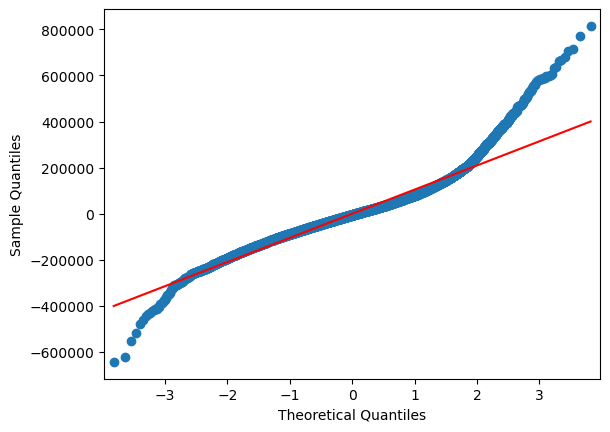

c:\Users\edian\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


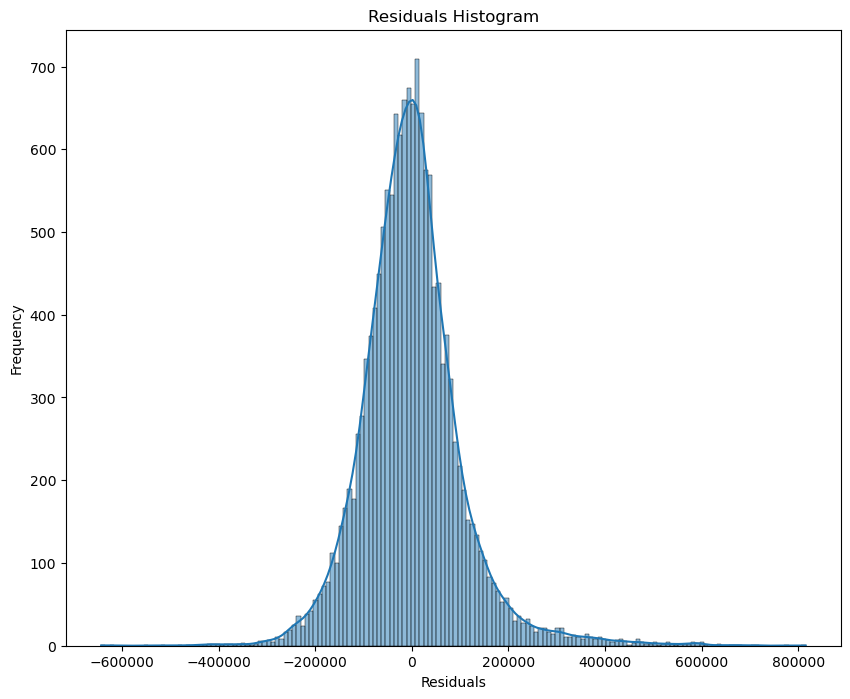

D = 0.5263685582514538, p-value = 0.0
Los residuos no parecen estar normalmente distribuidos. :(


In [21]:
from scipy.stats import kstest

residuals = model.resid
sm.qqplot(residuals, line='s')
plt.show()


plt.figure(figsize=(10, 8))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

D, p_value = kstest(residuals, 'norm')

print(f"D = {D}, p-value = {p_value}")

if p_value > 0.05:
    print("Los residuos parecen estar normalmente distribuidos.")
else:
    print("Los residuos no parecen estar normalmente distribuidos. :(")

Al principio nos asustamos un poco. Que iba a pensar el señor secretario de nosotros??? Seguramente se iba a dar cuenta de que si los residuos no están normalmente distribuidos esto podría hacer que los intervalos de confianza y las pruebas de hipótesis que se basan en la normalidad de los residuos pudieran no ser válidos o pudiera ser una señal de que nuestro modelo no estaba capturando correctamente alguna característica de los datos. Pensándolo mejor nada de esto nos sorprendía y terminamos por restarle importancia al asunto e irnos a dormir

Un cierto día a nuestra oficina llegó una encargada de la Oficina de Igualdad de Modelos y nos dió mil razones por las que necesitaba asegurarse de que nuestros residuos cumplen la homocedasticidad. Nosotros éramos de mente bastante abierta así que decidimos colaborar en todo lo que pudiéramos para ayudar a la señorita.

In [ ]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

residuos_estandarizados = residuals / np.std(residuals)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuos_estandarizados)), residuos_estandarizados)
plt.title('Residuos Estandarizados vs. Recuentos')
plt.xlabel('Recuentos')
plt.ylabel('Residuos Estandarizados')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, residuals)
plt.title('Residuos vs. Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.show()


names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)

print(lzip(names, test))

if test[1] > 0.05:
    print("No se rechaza la hipótesis nula de homocedasticidad.")
else:
    print("Se rechaza la hipótesis nula de homocedasticidad.")



Luego de confirmarse que los residuos de nuestro modelo eran heterocedásticos la señorita parecía un poco decepcionada, seguramente porque se dió cuenta de que esto implicaba que su varianza cambiaba con el valor de las variables independientes y esto podía ser un problema porque la homocedasticidad es un supuesto clave en la regresión lineal, y si no se cumple, podría llevar a estimaciones sesgadas de los errores estándar y a pruebas de hipótesis inválidas.

Aún así hizo de tripas corazón, nos dió las gracias por ayudarla y se fue, muy probablemente a comprobar el supuesto de homocedasticidad de los residuos de otros modelos por ahí. Como no teníamos nada que hacer en el día nos pusimos a hacer regresión de las variables con respecto al precio para matar el rato

In [ ]:
plt.figure(figsize=(10, 8))
for i, column in enumerate(X.columns):
    plt.subplot(4, 4, i + 1)
    sns.scatterplot(x=X_train[column], y=y_train,s=2)
    plt.xlabel(column)
    plt.ylabel('Price')
    plt.title(f'{column} vs Price')
    plt.tight_layout()

    model2 = sm.OLS(y_train, X_train[column]).fit()
    plt.plot(X_train[column], model2.predict(X_train[column]), color='red')

plt.show()

Era esta una fresca mañana de invierno, que por estas latitudes suele ser la más agradable de las estaciones, cuando nos encontrábamos todos ya en la oficina descansando, pues, la jornada anterior de descanso en nuestra casa había resultado demasiado agotadora. "Para un cuerpo cansado cualquier cosa es una cama" dijo una vez un sabio, y era verdad. Donde sea que hubiera medio metro cuadrado de superficie horizontal algún compañero nuestro aprovechaba para tirarse a dormir sobre un improvisado colchón de papeles arrugados que alguna vez fueron reportes estadísticos. De repente, sin previo aviso, empezó a resonar por toda la oficina el ruido familiar de mal augurio que precedía siempre a las visitas del gobernador. "Tac tac tac" se iban acercando poco a poco las pisadas por el pasillo, con cada una se despertaba uno de nuestros compañeros y con la siguiente ya estaba en posición vertical preparado para fingir con todas sus fuerzas que tenía ganas de chambear durante los minutos que durara la presencia del no invitado. Una vez entró por la puerta, el gobernador encontró una oficina radicalmente diferente de lo que había sido apenas unos segundos atrás, con cada trabajador enfrascado en alguna tarea, fuera cual fuera. Fue en ese ambiente rebosante de falsa energía que el gobernador lanzó su saludo.

--Como tan muchacho, yo lo veo a ustede muuuy bieeeen

--Todo bien señor gobernador, aquí nos ve, ganándonos el pan de cada día como siempre --dijo el mas cercano de nosotros--

--Muy bien, muy bien. Bueno no se si se han fijado pero los aliens nos invaden

--Qué???

--Los aliens nos invaden

--A

--Bueno como sea nos mandaron en un comunicado que a menos que los derrotemos en un concurso de predecir precios de casas mañana van a apoderarse de Seattle, porfi usen su modelo de los 33 mil millones para defendernos

--Ok 

--Bueno les deseo suerte la competencia es mañana a las 10:00 A.M.

Y se fue por donde mismo entró

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

def train_pytorch_model(X_train, X_test, y_train, y_test):
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    class HousePricePredictor(nn.Module):
        def __init__(self):
            super(HousePricePredictor, self).__init__()
            self.fc1 = nn.Linear(X_train.shape[1], 64)
            self.fc2 = nn.Linear(64, 64)
            self.fc3 = nn.Linear(64, 32)
            self.fc4 = nn.Linear(32, 1)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = torch.relu(self.fc3(x))
            x = self.fc4(x)
            return x

    model_torch = HousePricePredictor()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_torch.parameters(), lr=0.001)

    best_loss = np.inf
    patience = 50
    patience_counter = 0

    num_epochs = 200
    for epoch in range(num_epochs):
        model_torch.train()
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            y_pred = model_torch(X_batch)
            loss = criterion(y_pred.view(-1), y_batch)
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    model_torch.eval()
    y_pred_tensor = model_torch(X_test_tensor)
    y_pred = y_pred_tensor.view(-1).detach().numpy()
    mse = mean_squared_error(y_test, y_pred)
    print(f'MSE: {mse}')

    return model_torch, mse

Los aliens tuvieron la bondad de mostrarnos su modelo, una flamante red neuronal hecha en Pytorch, muy probablemente con menos de 33311738311.36294 de error cuadrático medio

In [ ]:
import xgboost as xgb

def train_xgboost_model(X_train, X_test, y_train, y_test):
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror')
    model_xgb.fit(X_train, y_train)

    y_pred = model_xgb.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    print(f'MSE: {mse}')

    return model_xgb, mse

Tan solo nos costó unas horas y la detención de uno de nuestros compañeros por infiltración en instituciones militares pero logramos hacernos con un modelo secreto de la NASA para predecir precios de casas, que al parecer estaba hecho en XGBoost.

La mañana de la competencia llegamos a la plaza del barrio que tenía código postal `98039`, al parecer ellos estaban patrocinando la competencia o algo así. Toda la ciudad Seattle se encontraba reunida allí esa mañana para ver el desenlace de tal peculiar invasión. Los aliens dijeron las reglas de la competencia: los modelos se pondrían en una máquina llamada ANOVA, que a través de métodos arcanos decidiría si había una diferencia estádisticamente significativa entre los modelos. Podíamos participar con cuantos modelos quisieramos pero ellos solo usarían uno. Dicho esto encendieron la tal ANOVA y con total elegancia introdujeron dentro su modelo de Pytorch. Nosotros, con la percepción de la realidad completamente alterada, humildemente introdujimos nuestro modelo de regresión lineal en la máquina, y luego con un poco más de fe introdujimos el que le pedimos prestada unilateralmente a la NASA. Los únicos que no estaban temblando eran los aliens... y las demás personas porque todos confiaban en nuestro maravilloso modelo de los 33 mil millones. Los únicos que estábamos temblando éramos nosotros.

In [ ]:
from scipy.stats import f_oneway
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


X = houses[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
            'waterfront', 'view', 'condition', 'grade', 'sqft_above',
            'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
            'sqft_lot15', 'zipcode_price_mean']]
y = houses['price']

kf = KFold(n_splits=3)
mse1=[]
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    _, mse,_,_ = linear_regression(X_train, X_test, y_train, y_test)
    mse1.append(mse)

kf = KFold(n_splits=3)
mse2= []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    _, mse = train_xgboost_model(X_train, X_test, y_train, y_test)
    mse2.append(mse)

kf = KFold(n_splits=3)
mse3= []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    _, mse = train_pytorch_model(X_train, X_test, y_train, y_test)
    mse3.append(mse)

f_stat, p_value = f_oneway(mse1,mse2,mse3)

if p_value < 0.05:
    print("There is a significant difference between the models.")
else:
    print("There is not a significant difference between the models.")


Cuando ANOVA sacó la respuesta resultó ser lo que todos en el equipo temíamos: "There is a significant difference between the models.". El público general nunca entendió por qué uno de nosotros se desmayó (otra vez). Tanto los aliens como los ciudadanos estaban seguros de haber ganado. Los aliens anunciaron que iban a aplicar una técnica para determinar quien había sido el ganador... 

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mse1 = np.array(mse1)
mse2 = np.array(mse2)
mse3 = np.array(mse3)

data = {'mse': np.concatenate([mse1, mse2, mse3]),
        'model': ['regression'] * 3 + ['xgboost'] * 3 + ['torch'] * 3}

df = pd.DataFrame(data)

model = ols('mse ~ model', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

posthoc = pairwise_tukeyhsd(df['mse'], df['model'], alpha=0.05)
print(posthoc)

El alien anciano mayor con calma sacó otra máquina de la nave que decía "Tukey HSD" e introdujo los resultados de ANOVA dentro de la máquina. Para ese momento hasta los miembros más oscuritos de nuestro equipo se veían pálidos como una hoja de papel, en contraste a la ciudadanía Seattlense que se hallaba eufórica al creer ser la primera ciudad del mundo en derrotar a los extraterrestres en un concurso de predecir precios de casas.

El alien anciano mayor sacó de la Tukey un papelito, en él se encontraba el nombre del ganador. Toda la ciudad hizo silencio. El anciano abrió el papel, lo miró detenidamente y dijo en voy alta: "QWEAAAA TYUUEEEEOOOPPAAAA!!!!!". El alien anciano mayor no hablaba español pero el alien traductor del anciano mayor repitió apenas medio segundo después: "El ganador es XGBoost!!!!"

A nuestro equipo le vino el alma al cuerpo con esas palabras. Sencillamente era un milagro. Ni siquiera lo pensamos más y nos unimos al pueblo en franca celebración. Los aliens estaban un poco decepcionados naturalmente, habían viajado más de 33311738311.36294 UA para venir a conquistar la Tierra a través del sofisticado método de vencer a sus habitantes en un concurso de predicción de precios de casas. Uno de los aliens de repente, con voz esperanzada gritó:

--Esperen, esperen, nunca comprobamos si se cumplen los supuestos para realizar ANOVA. Llamen al VAR

In [ ]:
from scipy.stats import shapiro

for group in df['model'].unique():
    group_data = df[df['model'] == group]['mse']
    _, p_value = shapiro(group_data)
    if p_value < 0.05:
        print(f"The {group} group is not normally distributed.")
    else:
        print(f"The {group} group is normally distributed.")

from scipy.stats import levene

levene(df[df['model'] == 'regression']['mse'],
         df[df['model'] == 'xgboost']['mse'],
         df[df['model'] == 'torch']['mse'])
if p_value < 0.05:
    print("The groups have different variances.")
else:
    print("The groups have equal variances.")


En el VAR enseguida cogieron los tres modelos y les aplicaron test de Shapiro-Wilk a los modelos para comprobar que los grupos distribuían normal. La máquina dió tres pitidos y prendió una luz verde. Los grupos distribuían normal. Luego sin perder ni una milésima procedieron a analizar si los grupos tenían iguales varianzas, para esto aplicaron el test de Levene. Nuevamente la máquina pitó tres veces y prendió una luz verde. Los jueces determinaron de forma unánime que no aplicarían el test para determinar si las observaciones eran independientes ya que debido a la naturaleza de los experimentos este supuesto se garantizaba. Dicho y hecho procedieron a llamar al alien anciano mayor para informarle que todo estaba en orden, cosa que él anunció (a través de su traductor) para beneplácito de toda la ciudad que había esperado en silencio a que saliera el veredicto. De inmediato estalló una fiesta generalizada en todos lados y, envueltos en agasajos y elogios, cada miembro del equipo disfrutaba de su merecida fama por haber sido los artífices de que por primera vez la humanidad derrotara a los aliens en una competencia de predecir precios de casas. 

Al día siguiente, cuando el gobernador pasó por la oficina a dejar la tarea nueva de la semana había solo un pobre diablo durmiendo sin ropa encima de unos periódicos. Los que no estaban con resaca en sus casas estaban celebrando todavía en algún rincón inhóspito de la ciudad. Dado el caso el gobernador decidió encargarle la tarea a ese pobre infeliz que la hizo a duras penas con las únicas fuerzas que tenía.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

houses_normalized = houses_numeric.dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(houses_normalized)

pca = PCA()

pca.fit(X_scaled)
components = pca.transform(X_scaled)

variance_ratio = pca.explained_variance_ratio_
plt.bar(np.arange(variance_ratio.shape[0]) + 1, variance_ratio)

In [ ]:
cum_variance = pca.explained_variance_ratio_.cumsum()
plt.stem(np.arange(variance_ratio.shape[0]) + 1, cum_variance)
plt.grid()

In [ ]:
component_count = 10
pca = PCA(component_count)
principalComponents = pca.fit_transform(houses_normalized)
principal_Df = pd.DataFrame(data = principalComponents)
analysis = pd.DataFrame(pca.components_, columns=houses_normalized.columns, index=[f'PC{i}' for i in range(1,component_count+1)]).T
sns.heatmap(analysis, vmin=-5e-1, vmax=5e-1)

La leyenda de haber derrotado a los aliens en una batalla de predecir precios de casas nos valió fama mundial, ciertamente ya no necesitábamos el parole, todos los paises querían tener a los héroes de la humanidad dentro de sus fronteras pero aún así nosotros decidimos que lo mejor sería mudarnos a Seattle. Esa casa de 33 habitaciones se veía demasiado tentadora, si iba a haber una recompensa material por nuestra hazaña definitivamente tenía que ser esa. Hablamos con el gobernador para que moviera unos cuantos hilos y en unos pocos días nos avisó de que la casa estaba disponible para nosotros. Digo piénsenlo bien, esa casa con 33 cuartos podía albergar a todo el equipo y a nuestras familias, y aún sobrarían habitaciones para las visitas. Con la mayor felicidad del mundo nos dirigimos todos a la famosa casa de los 33 cuartos, esperando llegar a una mansión magnífica que fuera nuestro nuevo bastión. Solo les voy a dar un consejo: 

![The house of the 33 rooms](home.png)

Nunca confíen en los datasets hechos por otras personas...

> Disclaimer:
Los sucesos de este notebook son puramente ficticios, cualquier semejanza con la realidad es pura coincidencia. Ningún estadígrafo resultó herido durante la realización de los experimentos